In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_file_from_google_drive

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import sys
import argparse
import os
import time
from os.path import join
import csv

print('PyTorch version:', torch.__version__)

# install wget for data sharing
# !pip install wget
import wget

PyTorch version: 2.0.1


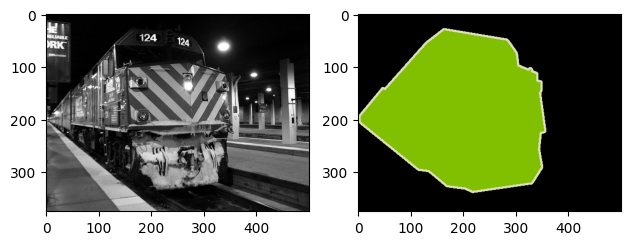

In [2]:
id = '2007_000123'

img = Image.open(os.path.join(f'./VOC/VOCdevkit/VOC2012/JPEGImages/{id}.jpg'))
mask = Image.open(os.path.join(f'./VOC/VOCdevkit/VOC2012/SegmentationClass/{id}.png'))

img_tensor = transforms.ToTensor()(img)
mask_tensor = transforms.ToTensor()(mask)

plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(mask)
plt.tight_layout()

In [3]:
res_size = (400,400)

transforms_NN = transforms.Resize(res_size, interpolation=transforms.InterpolationMode.NEAREST)
transforms_NN_exact = transforms.Resize(res_size, interpolation=transforms.InterpolationMode.NEAREST_EXACT)
transforms_BiLINEAR = transforms.Resize(res_size, interpolation=transforms.InterpolationMode.BILINEAR)
transforms_BiCUBIC = transforms.Resize(res_size, interpolation=transforms.InterpolationMode.BICUBIC)

img_NN = transforms.ToPILImage()(transforms_NN(img_tensor))
img_NN_exact = transforms.ToPILImage()(transforms_NN_exact(img_tensor))
img_BiLINEAR = transforms.ToPILImage()(transforms_BiLINEAR(img_tensor))
img_BiCUBIC = transforms.ToPILImage()(transforms_BiCUBIC(img_tensor))

mask_NN = transforms.ToPILImage()(transforms_NN(mask_tensor))
mask_NN_exact = transforms.ToPILImage()(transforms_NN_exact(mask_tensor))
mask_BiLINEAR = transforms.ToPILImage()(transforms_BiLINEAR(mask_tensor))
mask_BiCUBIC = transforms.ToPILImage()(transforms_BiCUBIC(mask_tensor))

/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


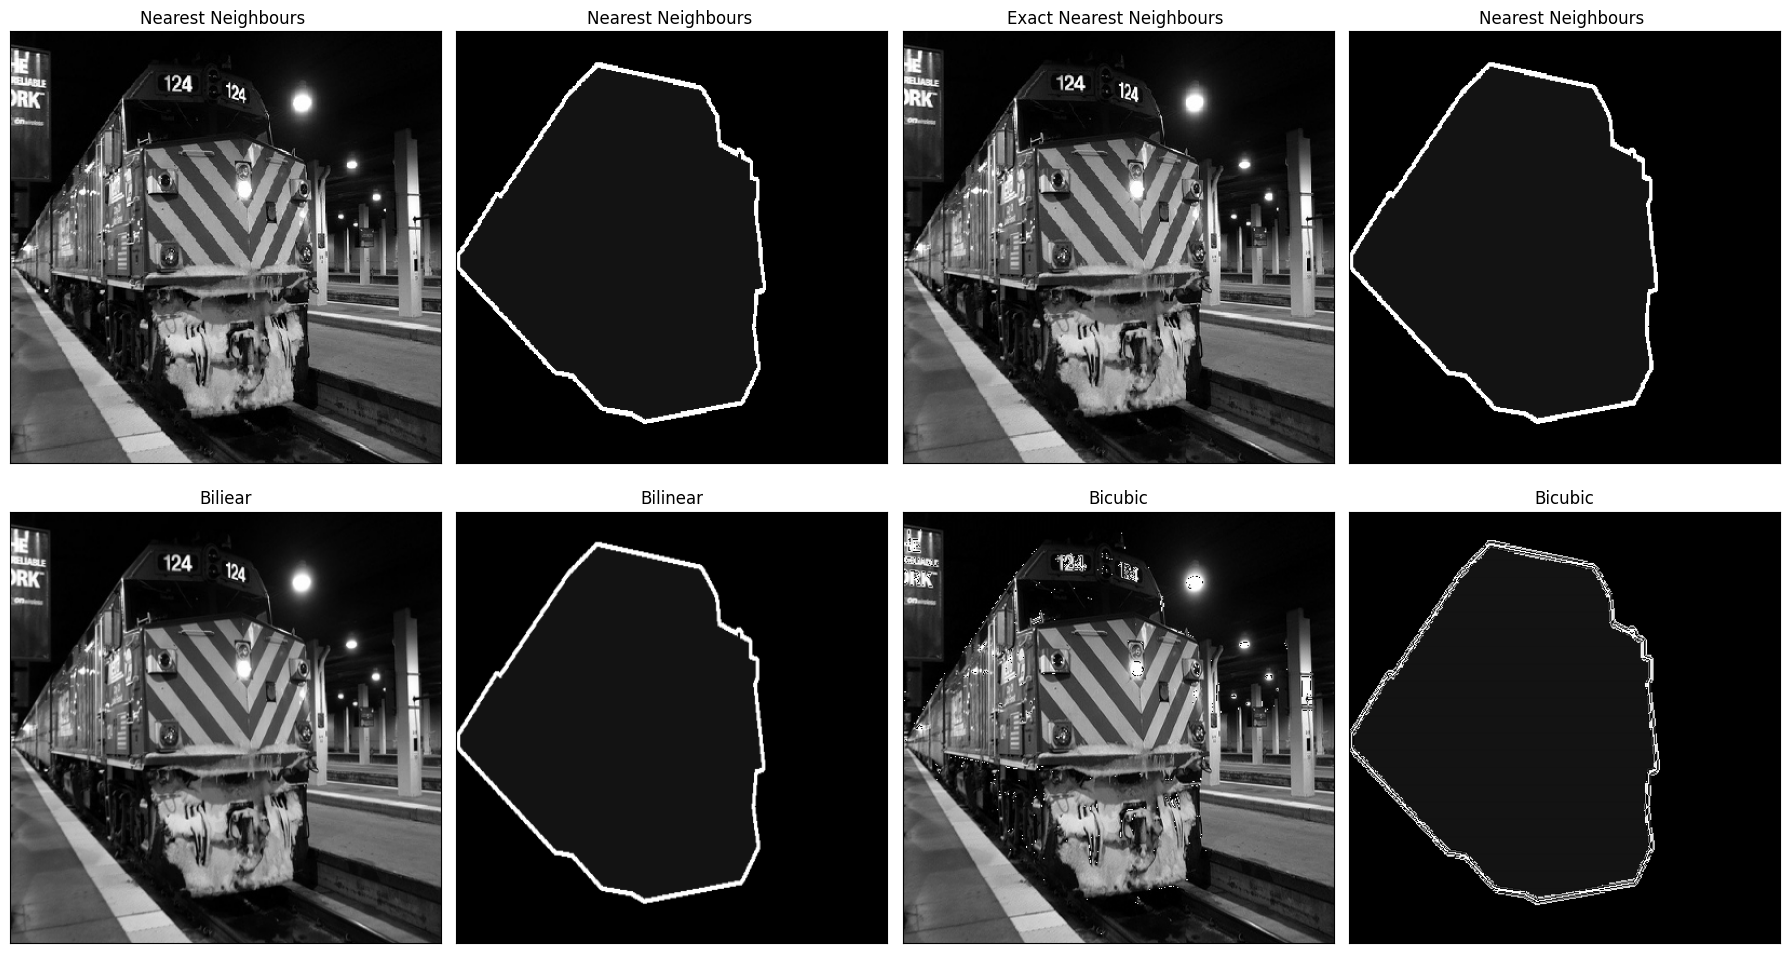

In [15]:

fig = plt.figure(figsize=(18, 10))

# Create a 2 by 2 grid of subplots
plt.subplot(2, 4, 1)  # Top-left subplot
plt.imshow(img_NN, cmap='gray')
plt.title('Nearest Neighbours ')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(2, 4, 2)  # Top-left subplot
plt.imshow(mask_NN, cmap='gray')
plt.title('Nearest Neighbours ')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

# Create a 2 by 2 grid of subplots
plt.subplot(2, 4, 3)  # Top-left subplot
plt.imshow(img_NN_exact, cmap='gray')
plt.title('Exact Nearest Neighbours ')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(2, 4, 4)  # Top-left subplot
plt.imshow(mask_NN_exact, cmap='gray')
plt.title('Nearest Neighbours ')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(2, 4, 5)  # Bottom-left subplot
plt.imshow(img_BiLINEAR, cmap='gray')
plt.title('Biliear')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(2, 4, 6)  # Top-right subplot
plt.imshow(mask_BiLINEAR, cmap='gray')
plt.title('Bilinear')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(2, 4, 7)  # Bottom-right subplot
plt.imshow(img_BiCUBIC, cmap='gray')
plt.title('Bicubic')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(2, 4, 8)  # Top-right subplot
plt.imshow(mask_BiCUBIC, cmap='gray')
plt.title('Bicubic')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

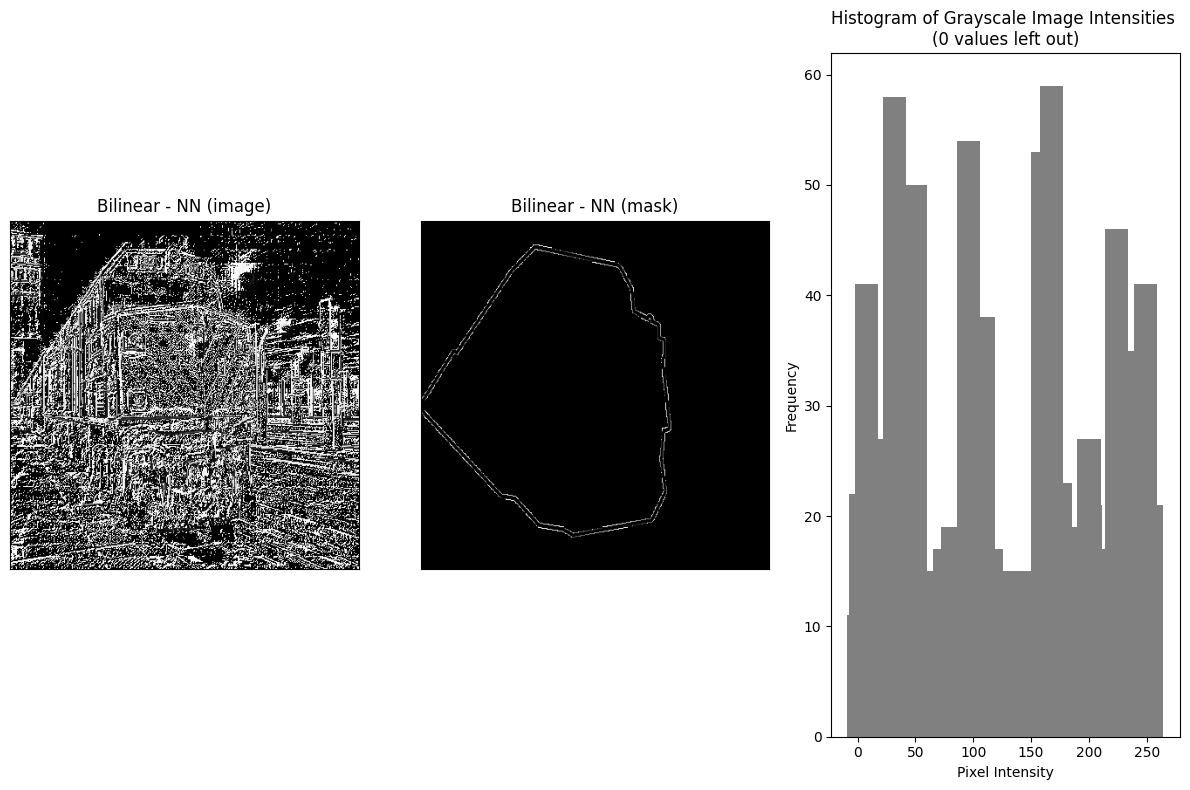

In [22]:
img_NN_np = np.array(img_NN.convert('L'))
img_BiLINEAR_np = np.array(img_BiLINEAR.convert('L'))

subs = np.abs(img_NN_np-img_BiLINEAR_np).reshape(res_size)
subs_im = Image.fromarray(subs)

mask_NN_np = np.array(mask_NN.convert('L'))
mask_BiLINEAR_np = np.array(mask_BiLINEAR.convert('L'))

subs = np.abs(mask_NN_np-mask_BiLINEAR_np).reshape(res_size)
mask_im = Image.fromarray(subs)

fig = plt.figure(figsize=(12, 8))
plt.subplot(1,3,1)
plt.title("Bilinear - NN (image)")
plt.imshow(subs_im, cmap='gray')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels
plt.subplot(1,3,2)
plt.title("Bilinear - NN (mask)")
plt.imshow(mask_im, cmap='gray')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

# Convert the PIL Image to a NumPy array
image_array = np.array(mask_im)
# Calculate the histogram
hist, bins = np.histogram(image_array[image_array!=0].flatten(), bins=255, range=[1, 256])

# Plot the histogram
plt.subplot(1,3,3)
plt.bar(bins[:-1], hist, width=20, color='gray')
plt.title('Histogram of Grayscale Image Intensities \n(0 values left out)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.tight_layout()

In [6]:
i, j, h, w = random.randint(0,int((400-224)/2)), random.randint(0,int((400-224)/2)), 224, 224

image_cropped = TF.resized_crop(img_tensor, i, j, h, w, res_size)
mask_cropped  = TF.resized_crop(mask_tensor, i, j, h, w, res_size)

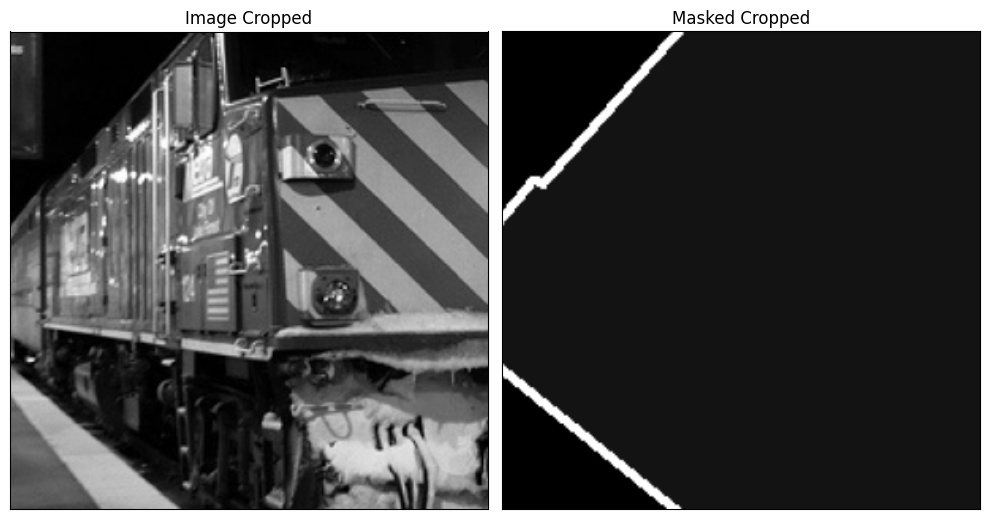

In [7]:
image_cropped_PIL = transforms.ToPILImage()(image_cropped)
mask_cropped_PIL = transforms.ToPILImage()(mask_cropped)

fig = plt.figure(figsize=(10, 8))

# Create a 2 by 2 grid of subplots
plt.subplot(1, 2, 1)  # Top-left subplot
plt.imshow(image_cropped_PIL)
plt.title('Image Cropped')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

plt.subplot(1, 2, 2)  # Top-right subplot
plt.imshow(mask_cropped_PIL, cmap='gray')
plt.title('Masked Cropped')
plt.xticks([])  # Remove x-axis ticks and labels
plt.yticks([])  # Remove y-axis ticks and labels

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()